In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def compute_graph_covariance(df, time_col='time'):
    """
    Given a DataFrame `df` with a time column (`t`) and
    multiple categorical or binary columns, this function:

      1. Converts each attribute to binary indicators (one-hot),
      2. Groups by time,
      3. Computes A_t(u,v) = (# samples with u=1 and v=1) / n_t,
      4. Returns Σ_t(u,v) = A_t(u,v) - A_t(u,u)*A_t(v,v).

    Returns a dictionary keyed by t, whose values are DataFrames
    representing the Σ_t matrix at each t.
    """
    # -- 1. One-hot encode (unless already binary) --
    time_series = df[time_col]
    feature_df = df.drop(columns=[time_col])
    feature_df = pd.get_dummies(feature_df, drop_first=False)
    
    binary_cols = feature_df.columns.tolist()
    encoded_df = pd.concat([time_series, feature_df], axis=1)
    
    # -- 2. Group by time, build A_t, then compute Σ_t --
    gc_dict = {}
    for t_value, group_df in encoded_df.groupby(time_col):
        n_t = len(group_df)
        if n_t == 0:
            continue
        
        # Turn to numpy array
        X = group_df[binary_cols].values.astype(float)  # shape: (n_t, p')
        
        # Compute A_t (E[X_u X_v]) via matrix multiplication
        A_t = (X.T @ X) / n_t  # p' x p'
        
        # Graph covariance: Σ_t = A_t - diag(A_t)*diag(A_t)^T
        diag_vals = np.diag(A_t)
        outer_diags = np.outer(diag_vals, diag_vals)
        Sigma_t = A_t - outer_diags
        
        # Store as a DataFrame for convenience
        gc_dict[t_value] = pd.DataFrame(Sigma_t, 
                                        index=binary_cols, 
                                        columns=binary_cols)
    
    return gc_dict

In [19]:
df = pd.read_csv("../simple_gen_data.csv")
gc_matrices = compute_graph_covariance(df, time_col="t")

print("Graph covariance matrices by time:")
for t, mat in gc_matrices.items():
    print(f"\nTime {t}:")
    print(mat.round(3))

Graph covariance matrices by time:

Time 1:
       X1     X2     X3     X4     X5     X6     X7
X1  0.156 -0.001  0.141  0.032  0.127  0.109  0.000
X2 -0.001  0.092 -0.001  0.000 -0.000 -0.001  0.001
X3  0.141 -0.001  0.144  0.030  0.114  0.099  0.001
X4  0.032  0.000  0.030  0.038  0.027  0.023  0.001
X5  0.127 -0.000  0.114  0.027  0.132  0.087  0.000
X6  0.109 -0.001  0.099  0.023  0.087  0.117  0.000
X7  0.000  0.001  0.001  0.001  0.000  0.000  0.094

Time 2:
       X1     X2     X3     X4     X5     X6     X7
X1  0.154 -0.001  0.140  0.045  0.104  0.080 -0.003
X2 -0.001  0.089 -0.001  0.001 -0.001 -0.002 -0.001
X3  0.140 -0.001  0.143  0.041  0.094  0.074 -0.002
X4  0.045  0.001  0.041  0.052  0.031  0.024  0.000
X5  0.104 -0.001  0.094  0.031  0.112  0.055 -0.003
X6  0.080 -0.002  0.074  0.024  0.055  0.089 -0.002
X7 -0.003 -0.001 -0.002  0.000 -0.003 -0.002  0.093

Time 3:
       X1     X2     X3     X4     X5     X6     X7
X1  0.163 -0.000  0.145  0.064  0.103  0.046  0.001
X2

In [24]:
times = sorted(gc_matrices.keys())

gc_12 = [gc_matrices[t].loc["X1","X2"] for t in times]  # (X1, X2)
gc_13 = [gc_matrices[t].loc["X1","X3"] for t in times]  # (X1, X3)
gc_14 = [gc_matrices[t].loc["X1","X4"] for t in times]  # (X1, X4)
gc_15 = [gc_matrices[t].loc["X1","X5"] for t in times]  # (X1, X5)
gc_16 = [gc_matrices[t].loc["X1","X6"] for t in times]  # (X1, X6)
gc_17 = [gc_matrices[t].loc["X1","X7"] for t in times]  # (X1, X7)

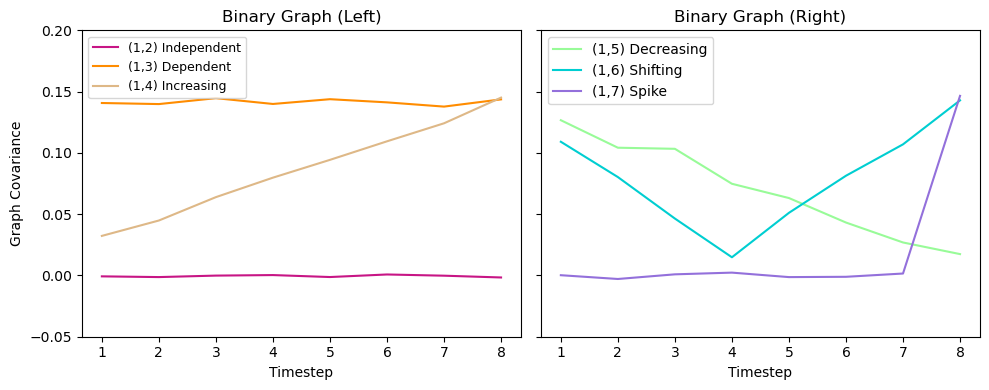

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

# Left: (X1,X2), (X1,X3), (X1,X4)
ax1.plot(times, gc_12, color = 'mediumvioletred', label='(1,2) Independent')
ax1.plot(times, gc_13, color = 'darkorange', label='(1,3) Dependent')
ax1.plot(times, gc_14, color = 'burlywood', label='(1,4) Increasing')
ax1.set_xlabel('Timestep')
ax1.set_ylabel('Graph Covariance')
ax1.set_title('Binary Graph (Left)')
ax1.legend(loc='upper left', fontsize='8')
ax1.set_ylim([-0.05, 0.2])  # adjust if needed

# Right: (X1,X5), (X1,X6), (X1,X7)
ax2.plot(times, gc_15, color = 'palegreen', label='(1,5) Decreasing')
ax2.plot(times, gc_16, color = 'darkturquoise', label='(1,6) Shifting')
ax2.plot(times, gc_17, color = 'mediumpurple', label='(1,7) Spike')
ax2.set_xlabel('Timestep')
ax2.set_title('Binary Graph (Right)')
ax2.legend(loc='upper left', fontsize='8')
ax2.set_ylim([-0.05, 0.2])  # adjust if needed

plt.tight_layout()
plt.show()